In [0]:
!pip install keras
!pip install opencv-python


In [0]:
!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install tqdm


In [0]:
!pip install kaggle
api_token = {"username":"sushilraje","key":"0b3bb4d990e2a043805e1a1e2570cd69"}
import json
import zipfile
import os
!echo '{"username":"sushilraje","key":"0b3bb4d990e2a043805e1a1e2570cd69"}' > ~/.kaggle/kaggle.json
!echo '{"username":"sushilraje","key":"0b3bb4d990e2a043805e1a1e2570cd69"}' > /content/kaggle.json


In [0]:
import zipfile
!chmod 600 /content/kaggle.json
!kaggle config path -p /content
!kaggle competitions download -c severstal-steel-defect-detection
os.chdir('/content/severstal-steel-defect-detection')


usage: kaggle config [-h] {view,set,unset} ...
kaggle config: error: argument command: invalid choice: 'path' (choose from 'view', 'set', 'unset')
  0% 0.00/6.91M [00:00<?, ?B/s]
100% 6.91M/6.91M [00:00<00:00, 113MB/s]
  0% 0.00/141k [00:00<?, ?B/s]
100% 141k/141k [00:00<00:00, 126MB/s]
 99% 1.15G/1.16G [00:14<00:00, 119MB/s]
100% 1.16G/1.16G [00:14<00:00, 85.6MB/s]
 91% 118M/129M [00:01<00:00, 64.3MB/s]
100% 129M/129M [00:01<00:00, 85.2MB/s]


In [0]:

import zipfile
for file in os.listdir():
  if(zipfile.is_zipfile(file)):
    print("Found zip file ", file)
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()
    zip_ref.close()

Found zip file  train_images.zip
Found zip file  train.csv.zip
Found zip file  test_images.zip


In [0]:
for file in os.listdir():
  if file == "sample_submission.csv":
    print(file)


sample_submission.csv


In [0]:
import os
import json
import random

import cv2
import keras as keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Flatten, Dense, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [0]:
ONLY_CLASSIFY = True
IMAGE_CHANNELS = 1

## PREPROCESSING

In [0]:
traindf=pd.read_csv('train.csv')
traindf['ImageId'] = traindf['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
traindf['ClassId'] = traindf['ImageId_ClassId'].apply(lambda x: x.split('_')[1])
traindf['hasMask'] = ~ traindf['EncodedPixels'].isna()
traindf.head()

,ImageId_ClassId,EncodedPixels,ImageId,ClassId,hasMask
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1,True
1,0002cc93b.jpg_2,NaN,0002cc93b.jpg,2,False
2,0002cc93b.jpg_3,NaN,0002cc93b.jpg,3,False
3,0002cc93b.jpg_4,NaN,0002cc93b.jpg,4,False
4,00031f466.jpg_1,NaN,00031f466.jpg,1,False


In [0]:
maskcountdf = traindf.groupby('ImageId').agg(np.sum).reset_index()
maskcountdf.sort_values('hasMask', ascending=False, inplace=True)
print(maskcountdf.shape)
maskcountdf.head()

(12568, 2)


,ImageId,hasMask
10803,db4867ee8.jpg,3.0
11776,ef24da2ba.jpg,3.0
6284,7f30b9c64.jpg,2.0
9421,bf0c81db6.jpg,2.0
9615,c314f43f3.jpg,2.0


In [0]:
sub_df = pd.read_csv('sample_submission.csv')
sub_df['ImageId'] = sub_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
test_imgs = pd.DataFrame(sub_df['ImageId'].unique(), columns=['ImageId'])

## UTILITY

In [0]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape=(256,1600)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [0]:
def build_masks(rles, input_shape):
    depth = len(rles)
    height, width = input_shape
    masks = np.zeros((height, width, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            masks[:, :, i] = rle2mask(rle, (width, height))
    
    return masks

def build_rles(masks):
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]
    
    return rles

def rles_classvect(rles):
    depth = 2
    masks = np.zeros((depth))
    masks[0] = 1
    masks[1] = 0
    for i, rle in enumerate(rles):
      if type(rle) is str:
          masks[0] = 0
          masks[1] = 1
    return masks

def random_flip(img):
  seed = random.randint(1,5)
  if seed % 3 == 0:
    img = np.flip(img, 0)
  if seed % 4 == 0:
    img = np.flip(img, 1)
  return img

In [0]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

## Sample

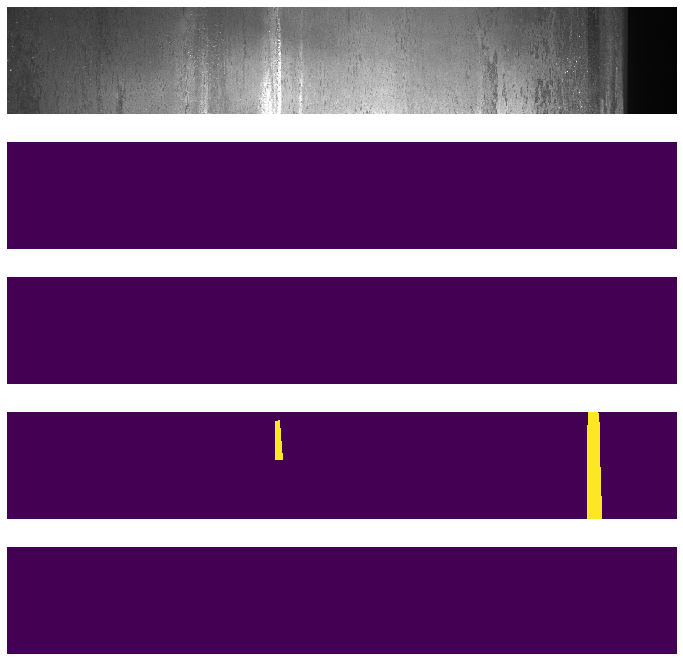

In [0]:
#/kaggle/input/severstal-steel-defect-detection/train_images/910540b7d.jpg
sample_filename = '910540b7d.jpg'
sample_image_df = traindf[traindf['ImageId'] == sample_filename]
sample_path = f"{sample_image_df['ImageId'].iloc[0]}"
sample_img = cv2.imread(sample_path)
sample_rles = sample_image_df['EncodedPixels'].values
sample_masks = build_masks(sample_rles, input_shape=(256, 1600))

fig, axs = plt.subplots(5, figsize=(12, 12))
axs[0].imshow(sample_img)
axs[0].axis('off')

for i in range(4):
    axs[i+1].imshow(sample_masks[:, :, i])
    axs[i+1].axis('off')

## Data Generation

In [0]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='/content/severstal-steel-defect-detection',
                 batch_size=32, dim=(256, 1600), n_channels=1,
                 n_classes=2, random_state=2019, shuffle=True, 
                 classify=False):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        self.classify = classify
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch, self.classify)
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            if self.n_channels == 3:
              img = self.__load_rgb(img_path)
            else:
              img = self.__load_grayscale(img_path)
            img = random_flip(img)
            
            # Store samples
            X[i,] = img
        return X

    def __generate_y(self, list_IDs_batch, classify=False):
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        if classify:
          y = np.empty((self.batch_size, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            rles = image_df['EncodedPixels'].values
            if classify:
              masks = rles_classvect(rles)
            else:
              masks = build_masks(rles, input_shape=self.dim)
            y[i, ] = masks
        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.
        return img


In [0]:
BATCH_SIZE = 16

train_idx, val_idx = train_test_split(
    maskcountdf.index, random_state=2019, test_size=0.15
)

train_generator = DataGenerator(
    train_idx, 
    df=maskcountdf,
    target_df=traindf,
    batch_size=BATCH_SIZE, 
    n_classes=2,
    n_channels=IMAGE_CHANNELS,
    classify=ONLY_CLASSIFY
)

val_generator = DataGenerator(
    val_idx, 
    df=maskcountdf,
    target_df=traindf,
    batch_size=BATCH_SIZE, 
    n_classes=2,
    n_channels=IMAGE_CHANNELS,
    classify=ONLY_CLASSIFY
)

In [0]:
def build_model(input_shape):
    """
    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (p4)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (c5)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

    c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='relu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='relu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    f10 = Flatten() (c9)
    d10 = Dense(16, activation='softmax') (f10)
    #d11 = Dense(16, activation='softmax') (d10)
    d12 = Dense(1, activation='softmax') (d10)

    outputs = d12
    model = Model(inputs=[inputs], outputs=[outputs])
    
    model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef])
    """
    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
    #c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = BatchNormalization() (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    #c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = BatchNormalization() (c2)
    p2 = MaxPooling2D((2, 2)) (c2)
    

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    #c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = BatchNormalization() (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(16, (3, 3), activation='relu', padding='same') (p3)
    #c4 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p4 = BatchNormalization() (c4)
    p4 = MaxPooling2D((2, 2)) (c4)

    c5 = Conv2D(8, (3, 3), activation='relu', padding='same') (p4)
    p5 = BatchNormalization() (c5)
    #c5 = Conv2D(8, (3, 3), activation='relu', padding='same') (c5)
    p5 = MaxPooling2D((2, 2)) (c5)

    f6 = Flatten() (p5)
    #d6 = Dense(16, activation='softmax') (f6)
    d6 = Dense(2, activation='softmax') (f6)

    outputs = d6

    model = Model(inputs=[inputs], outputs=[outputs])
    
    model.compile(
        optimizer=keras.optimizers.SGD(), 
        loss=keras.losses.categorical_crossentropy, 
        metrics=[keras.metrics.categorical_accuracy])
    return model

In [0]:
model = build_model((256, 1600, 1))
model.summary()















Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 1600, 1)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 1600, 8)      80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 800, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 800, 16)      1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 400, 16)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 400, 32)       4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 200, 

In [0]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_dice_coef', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    use_multiprocessing=True,
    epochs=70
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/70
667/667 [==============================] - 165s 247ms/step - loss: 0.6879 - categorical_accuracy: 0.5365 - val_loss: 0.6813 - val_categorical_accuracy: 0.6234
Epoch 2/70


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:707: RuntimeWarning: Can save best model only with val_dice_coef available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


667/667 [==============================] - 171s 256ms/step - loss: 0.6575 - categorical_accuracy: 0.6047 - val_loss: 0.6368 - val_categorical_accuracy: 0.6277
Epoch 3/70
667/667 [==============================] - 170s 255ms/step - loss: 0.6233 - categorical_accuracy: 0.6509 - val_loss: 0.6041 - val_categorical_accuracy: 0.6496
Epoch 4/70
667/667 [==============================] - 173s 259ms/step - loss: 0.5880 - categorical_accuracy: 0.6840 - val_loss: 0.5459 - val_categorical_accuracy: 0.7222
Epoch 5/70
667/667 [==============================] - 169s 254ms/step - loss: 0.5440 - categorical_accuracy: 0.7212 - val_loss: 0.5681 - val_categorical_accuracy: 0.7046
Epoch 6/70
667/667 [==============================] - 171s 256ms/step - loss: 0.5191 - categorical_accuracy: 0.7374 - val_loss: 0.5186 - val_categorical_accuracy: 0.7345
Epoch 7/70
667/667 [==============================] - 172s 258ms/step - loss: 0.5046 - categorical_accuracy: 0.7485 - val_loss: 0.5131 - val_categorical_accuracy

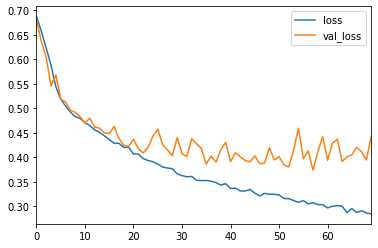

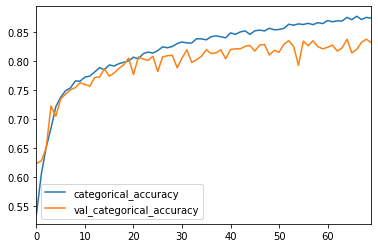

In [0]:
import json
with open('/content/history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['categorical_accuracy', 'val_categorical_accuracy']].plot()

In [0]:
model.save('/content/simple_cnn_model.h5')